In [1]:
%reload_ext autoreload
%autoreload 2
import json
import logging
import numpy as np
import pandas as pd
from pyeed import Pyeed
import matplotlib.pyplot as plt
import itertools
from pyeed.analysis.embedding_analysis import EmbeddingTool
from scipy.spatial.distance import pdist, squareform


/home/nab/anaconda3/envs/pyeed_niklas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
uri = "bolt://127.0.0.1:1123"
user = "neo4j"
password = "niklasonlytems"

eedb = Pyeed(uri, user=user, password=password)

📡 Connected to database.


In [3]:
# read in the ids.json file form this directory
with open("/home/nab/Niklas/TEM-lactamase/data/TEM_Ids/TEM_Ids.json", "r") as f:
    dict_id_name = json.load(f)

print(dict_id_name)

{'AAP20891': 'TEM-1', 'CAJ85677': 'TEM-2', 'SAQ02853': 'TEM-3', 'CDR98216': 'TEM-4', 'WP_109963600': 'TEM-5', 'CAA41038': 'TEM-6', 'WP_109874025': 'TEM-7', 'CAA46344': 'TEM-8', 'APG33178': 'TEM-9', 'AKC98298': 'TEM-11', 'KJO56189': 'TEM-12', 'KLP91446': 'TEM-15', 'CAA46346': 'TEM-16', 'CAA74912': 'TEM-17', 'AFN21551': 'TEM-19', 'ACB22021': 'TEM-20', 'CAA76794': 'TEM-21', 'CAA76795': 'TEM-22', 'CCG28759': 'TEM-24', 'KLG19745': 'TEM-26', 'AAC32891': 'TEM-28', 'CAA76796': 'TEM-29', 'CAD24670': 'TEM-30', 'ARF45649': 'TEM-31', 'CTA52364': 'TEM-32', 'ADL13944': 'TEM-33', 'AGQ50511': 'TEM-34', 'AKA60778': 'TEM-35', 'APT65830': 'TEM-36', 'HAH6232254': 'TEM-37', 'QDO66746': 'TEM-39', 'CBX53726': 'TEM-40', 'AAC32889': 'TEM-43', 'CAA64682': 'TEM-45', 'CAA71322': 'TEM-47', 'CAA71323': 'TEM-48', 'CAA71324': 'TEM-49', 'AEC32455': 'TEM-52', 'AAD22538': 'TEM-53', 'AAD22539': 'TEM-54', 'ABB97007': 'TEM-55', 'ACJ43254': 'TEM-57', 'AAC05975': 'TEM-60', 'BCD58813': 'TEM-61', 'AAK17194': 'TEM-63', 'AAD3311

In [4]:
# Query to get all proteins from the tem id list with embeddings and get the label based on the annotations
# careful the dict has the key as AAP20891 and the database has a key as AAP20891.1
# we therefor load all accession_id from all proteins and then filter the proteins based on the accession_id
query = """
MATCH (p:Protein)
WHERE p.accession_id IS NOT NULL
RETURN p.accession_id AS protein_id
"""

results_all_ids = [record["protein_id"] for record in eedb.db.execute_read(query)]

ids = []

for i in results_all_ids:
    if i.split(".")[0] in dict_id_name.keys():
        ids.append(i)

print(f"Number of proteins in the database: {len(results_all_ids)}")
print(f"Number of proteins in the database with IDS matching the TEM ids: {len(ids)}")
print(f"Sample of ids: {ids[:5]}")


Number of proteins in the database: 1253
Number of proteins in the database with IDS matching the TEM ids: 209
Sample of ids: ['AAC05975.1', 'AAC32889.2', 'AAC32891.1', 'AAD22538.1', 'AAD22539.1']


In [5]:
file_path_label = '/home/nab/Niklas/TEM-lactamase/data/TEM_Ids/TEM_bldb_csv.csv'
df = pd.read_csv(file_path_label, sep=';')
# label columns is Bush_Jacoby_Class
id_labels = df[['Protein name', 'Phenotype']]
# convert it in a dict
dict_id_label = dict(zip(id_labels['Protein name'], id_labels['Phenotype']))
print(dict_id_label)

# the keys right now are TEM-1, TEM-2, etc. and the keys need to changed to AAP20891, from dict_id_name
dict_id_label_new = {}
for key in dict_id_name.keys():
    value = dict_id_name[key]
    # key is id, value is name
    if value in dict_id_label.keys():
        dict_id_label_new[key] = dict_id_label[value]

print(f"Sample of labels: {dict_id_label_new.keys()}")

# now there is the same problem a sbefore with the keys in the dict and the keys in the database
# we need to chnage the keys in the dict to match the keys in the database
dict_id_label_new_ids = {}
for i in results_all_ids:
    if i.split(".")[0] in dict_id_label_new.keys():
        dict_id_label_new_ids[i] = dict_id_label_new[i.split(".")[0]]

print(f"Sample of labels: {dict_id_label_new_ids.keys()}")
print(f"Sample of labels: {dict_id_label_new_ids}")

# some of them are still nan or ? both shoudl be None
dict_id_label_new_ids_none = {}
for key, value in dict_id_label_new_ids.items():
    if value == 'nan' or value == '?':
        dict_id_label_new_ids_none[key] = None
    # check nan but not as string, it is a pandas nan
    elif not pd.notna(value):
        dict_id_label_new_ids_none[key] = None
    else:
        dict_id_label_new_ids_none[key] = value

print(f"Sample of labels: {dict_id_label_new_ids_none}")

# next ensure that all of the proteins have a lable if it is missing do none
# dict_id_label_new_ids_none and ids have to have the same the missing on should be None
ids_with_labels = []
labels = []
for i in ids:
    if i not in dict_id_label_new_ids_none.keys():
        dict_id_label_new_ids_none[i] = None

print(f"Final length ids: {len(ids)} and labels {len(dict_id_label_new_ids_none)}")


{'TEM-1': '2b', 'TEM-2': '2b', 'TEM-3': '2be', 'TEM-4': '2be', 'TEM-5': '2be', 'TEM-6': '2be', 'TEM-7': '2be', 'TEM-8': '2be', 'TEM-9': '2be', 'TEM-10': '2be', 'TEM-11': '2be', 'TEM-12': '2be', 'TEM-13': '2b', 'TEM-14': nan, 'TEM-15': '2be', 'TEM-16': '2be', 'TEM-17': '2be', 'TEM-18': '2be', 'TEM-19': '2be', 'TEM-20': '2be', 'TEM-21': '2be', 'TEM-22': '2be', 'TEM-23': nan, 'TEM-24': '2be', 'TEM-25': '2be', 'TEM-26': '2be', 'TEM-27': '2be', 'TEM-28': '2be', 'TEM-29': '2be', 'TEM-30': '2br', 'TEM-31': '2br', 'TEM-32': '2br', 'TEM-33': '2br', 'TEM-34': '2br', 'TEM-35': '2br', 'TEM-36': '2br', 'TEM-37': '2br', 'TEM-38': '2br', 'TEM-39': '2br', 'TEM-40': '2br', 'TEM-41': nan, 'TEM-42': nan, 'TEM-43': '2be', 'TEM-44': '2br', 'TEM-45': '2br', 'TEM-46': '2be', 'TEM-47': '2be', 'TEM-48': '2be', 'TEM-49': '2be', 'TEM-50': '2ber', 'TEM-51': '2br', 'TEM-52': '2be', 'TEM-53': '2be', 'TEM-54': '2br', 'TEM-55': '2b', 'TEM-56': '2be', 'TEM-57': '2b', 'TEM-58': '2br', 'TEM-59': nan, 'TEM-60': '2be', 'T

In [6]:
# all of the proteins need to be written into a pandas dataframe and then to a csv file
# the csv file should have the following columns: protein_id, protein_id_database, protein_name, phenotype
# the protein_id_database is the id from the database and the protein_id is the id from the dict
# the protein_name is the name from the dict and the phenotype is the label from the dict
# the csv file should be saved in the data folder

dataframe = []

# add protein_name and phenotype to the dataframe
for key in dict_id_label.keys():
    dataframe.append({'protein_name': key, 'phenotype': dict_id_label[key]})

print(dataframe[:5])

# add protein_id to the dataframe
for key in dict_id_name.keys():
    for row in dataframe:
        if row['protein_name'] == dict_id_name[key]:
            row['protein_id'] = key

print(dataframe[:5])

# add protein_id_database to the dataframe
for row in dataframe:
    for id in results_all_ids:
        if 'protein_id' in row.keys():
            if row['protein_id'] == id.split(".")[0]:
                row['protein_id_database'] = id


        

print(len(dataframe))

# write the dataframe to a csv file
df = pd.DataFrame(dataframe)
df.to_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', index=True, sep=';')

[{'protein_name': 'TEM-1', 'phenotype': '2b'}, {'protein_name': 'TEM-2', 'phenotype': '2b'}, {'protein_name': 'TEM-3', 'phenotype': '2be'}, {'protein_name': 'TEM-4', 'phenotype': '2be'}, {'protein_name': 'TEM-5', 'phenotype': '2be'}]
[{'protein_name': 'TEM-1', 'phenotype': '2b', 'protein_id': 'AAP20891'}, {'protein_name': 'TEM-2', 'phenotype': '2b', 'protein_id': 'CAJ85677'}, {'protein_name': 'TEM-3', 'phenotype': '2be', 'protein_id': 'SAQ02853'}, {'protein_name': 'TEM-4', 'phenotype': '2be', 'protein_id': 'CDR98216'}, {'protein_name': 'TEM-5', 'phenotype': '2be', 'protein_id': 'WP_109963600'}]
265


Number of proteins fetched with embeddings: 209
Number of proteins in id list: 209
{'2be', '2b', '2ber', 'None', '2br', 'ESBL'}
{'2be': 'blue', '2b': 'purple', '2ber': 'orange', 'None': 'black', '2br': 'green', 'ESBL': 'brown'}


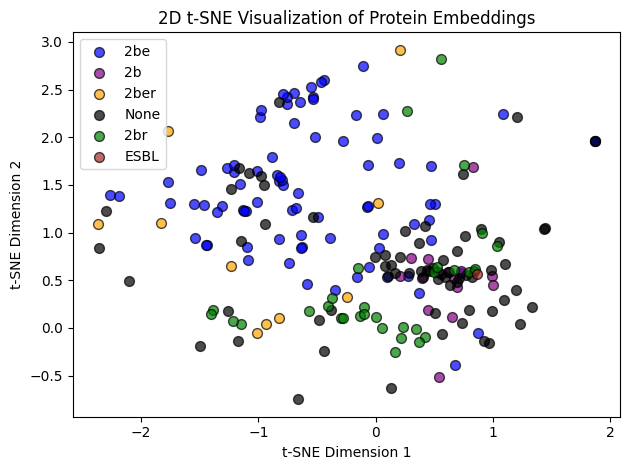

In [11]:
# get all of the data from embedding
embedding_tool = EmbeddingTool()
protein_ids, embeddings_2d, labels, colors = embedding_tool.visualization_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label_new_ids_none, perplexity=150, n_iter=3000)

# make the Noen objects to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# create a scatter plot for each unique label
unique_labels = set(labels)
unique_color_labels = {}
print(unique_labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )
    
    # store the color for the label
    unique_color_labels[label] = colors[indices[0]]

print(unique_color_labels)

plt.title("2D t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
print(len(ids))

209


In [19]:
# next up is the comaprision of embeddings vs identity
# we want a graph x is cosine similarity and y is identity
# we have all of the data in the database so we can just query it

# first we want the PAIRWISE_ALINED realtionship between the proteins from ids
# second we want thhe embeddduing of the proteins from ids
# we can then calculate the cosine similarity between the embeddings and the identity
query_pairwise = """
MATCH (p1:Protein)-[r:PAIRWISE_ALIGNED]-(p2:Protein)
WHERE p1.accession_id IN $ids AND p2.accession_id IN $ids
RETURN p1.accession_id AS protein1, p2.accession_id AS protein2, r.similarity AS identity, r.target_aligned AS target_aligned, r.query_aligned AS query_aligned, r.mismatches AS mismatches
"""
results_pairwise = eedb.db.execute_read(query_pairwise, {"ids": ids})
print(results_pairwise[:10])

# create a distance matrix based on the pairwise alignment
# the metric used will be identity
# results_pairwise is a list of dictionaries with keys protein1, protein2, identity
# the distance matrix is a numpy array, and there is a list of the protein ids which are the same as the order of the distance matrix
distance_matrix_pairwise = np.zeros((len(ids), len(ids)))
# protein_ids_pairwise is a list of the protein ids which are the same as the order of the distance matrix
# is should have a length of ids, the x and y axis of the distance matrix are the same
protein_ids_pairwise = []

for i in ids:
    for j in ids:
        if i == j:
            distance_matrix_pairwise[ids.index(i), ids.index(j)] = 1
        else:
            # this is the new identity, we look at the target and query seq and find remove all positions with a '-'
            # then we count the number of mismatches and divide by the length of the sequence
            # the identity is 1 - the number of mismatches / the length of the sequence

            # get the data from the results_pairwise
            target_aligned = next(
                (record["target_aligned"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), ''
            )
            query_aligned = next(
                (record["query_aligned"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), ''
            )
            mismatches = next(
                (record["mismatches"] for record in results_pairwise if record["protein1"] == i and record["protein2"] == j), 0
            )

            # remove the '-' from the target and query aligned
            remove_indices = []
            for k in range(len(target_aligned)):
                if target_aligned[k] == '-':
                    remove_indices.append(k)
                elif query_aligned[k] == '-':
                    remove_indices.append(k)
                
            # remove the indices from the target and query aligned
            target_aligned = ''.join([target_aligned[k] for k in range(len(target_aligned)) if k not in remove_indices])
            query_aligned = ''.join([query_aligned[k] for k in range(len(query_aligned)) if k not in remove_indices])

            # calculate the identity
            identity = 1 - mismatches / len(target_aligned)

            distance_matrix_pairwise[ids.index(i), ids.index(j)] = identity
            
    protein_ids_pairwise.append(i)

    


print(len(protein_ids_pairwise))
print(distance_matrix_pairwise.shape)


[{'protein1': 'CAC85661.1', 'protein2': 'AAP20891.1', 'identity': 0.9825174825174825, 'target_aligned': 'MSIQHFRVALIPFFAAFCFPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVKYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTTPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGASERGSRGIIAALGPDGKPSRIVVIYMTGSQATMDERNRQIAEIGASLIKHW', 'query_aligned': 'MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW', 'mismatches': 5}, {'protein1': 'CAC85661.1', 'protein2': 'CAC85660.1', 'identity': 0.986013986013986, 'target_aligned': 'MSIQHFRVALIPFFAAFCFPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVKYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDT

In [20]:
np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_pairwise_new.npy', distance_matrix_pairwise)
np.save('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_pairwise_new.npy', protein_ids_pairwise)


In [21]:
query_embedding = """
MATCH (p:Protein)
WHERE p.accession_id IN $ids
RETURN p.accession_id AS protein, p.embedding AS embedding
"""
results_embedding = eedb.db.execute_read(query_embedding, {"ids": ids})

# create a distance matrix based on the embeddings
# the metric used will be cosine similarity
# result is a numpy array and there is a list of the protein ids which are the same as the order of the distance matrix
distance_matrix_embedding = np.zeros((len(ids), len(ids)))
protein_ids_embedding = []

# use pdist to calculate the cosine similarity
# use squareform to get the distance matrix
embeddings = [record["embedding"] for record in results_embedding]
distance_matrix_embedding_cosine = squareform(pdist(embeddings, metric="cosine"))
distance_matrix_embedding_euclidean = squareform(pdist(embeddings, metric="euclidean"))
protein_ids_embedding = [record["protein"] for record in results_embedding]

In [22]:
# matrix sizes should be the same
print(distance_matrix_pairwise.shape)
print(distance_matrix_embedding_cosine.shape)
print(distance_matrix_embedding_euclidean.shape)

print(len(protein_ids_pairwise))
print(len(protein_ids_embedding))
print(len(protein_ids_embedding)//2)
print((len(protein_ids_embedding)//2)**2)

(209, 209)
(209, 209)
(209, 209)
209
209
104
10816


In [28]:
print(protein_ids_pairwise[:5])
print(protein_ids_embedding[:5])

['AAC05975.1', 'AAC32889.2', 'AAC32891.1', 'AAD22538.1', 'AAD22539.1']
['CAC85661.1', 'AML08013.1', 'ADP20705.1', 'QDC28520.1', 'ABO64442.1']


In [29]:
# create a scatter plot of the cosine similarity vs identity
# use as the color the label which is the phenotype and was calculated before
# when comparing two proteins with the same phenotype use the color of the phenotype otherwise use gray
# the x axis is the cosine similarity and the y axis is the identity

# get the colors for the proteins, colors is a matrix as well but with strings
import random
from turtle import color


colors = np.zeros((len(protein_ids), len(protein_ids)), dtype=object)
# if the proteins have the same label use the color of the label otherwise use gray
for i in protein_ids:
    for j in protein_ids:
        if i == j:
            continue
        if dict_id_label_new_ids_none[i] == dict_id_label_new_ids_none[j]:
            if dict_id_label_new_ids_none[i] == None:
                colors[protein_ids.index(i), protein_ids.index(j)] = 'black'
            else:
                colors[protein_ids.index(i), protein_ids.index(j)] = unique_color_labels[dict_id_label_new_ids_none[i]]
        else:
            colors[protein_ids.index(i), protein_ids.index(j)] = 'gray'

# get the labels for the proteins
labels = [dict_id_label_new_ids_none[i] for i in protein_ids]

# make the Noen objects to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# create a scatter plot for each unique label
unique_labels = set(labels)
print(unique_labels)

{'2be', '2b', '2ber', 'None', '2br', 'ESBL'}


 Length of protein_ids_mutations: 209
 Length of protein_ids_pairwise: 209


/tmp/ipykernel_673301/4050067144.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


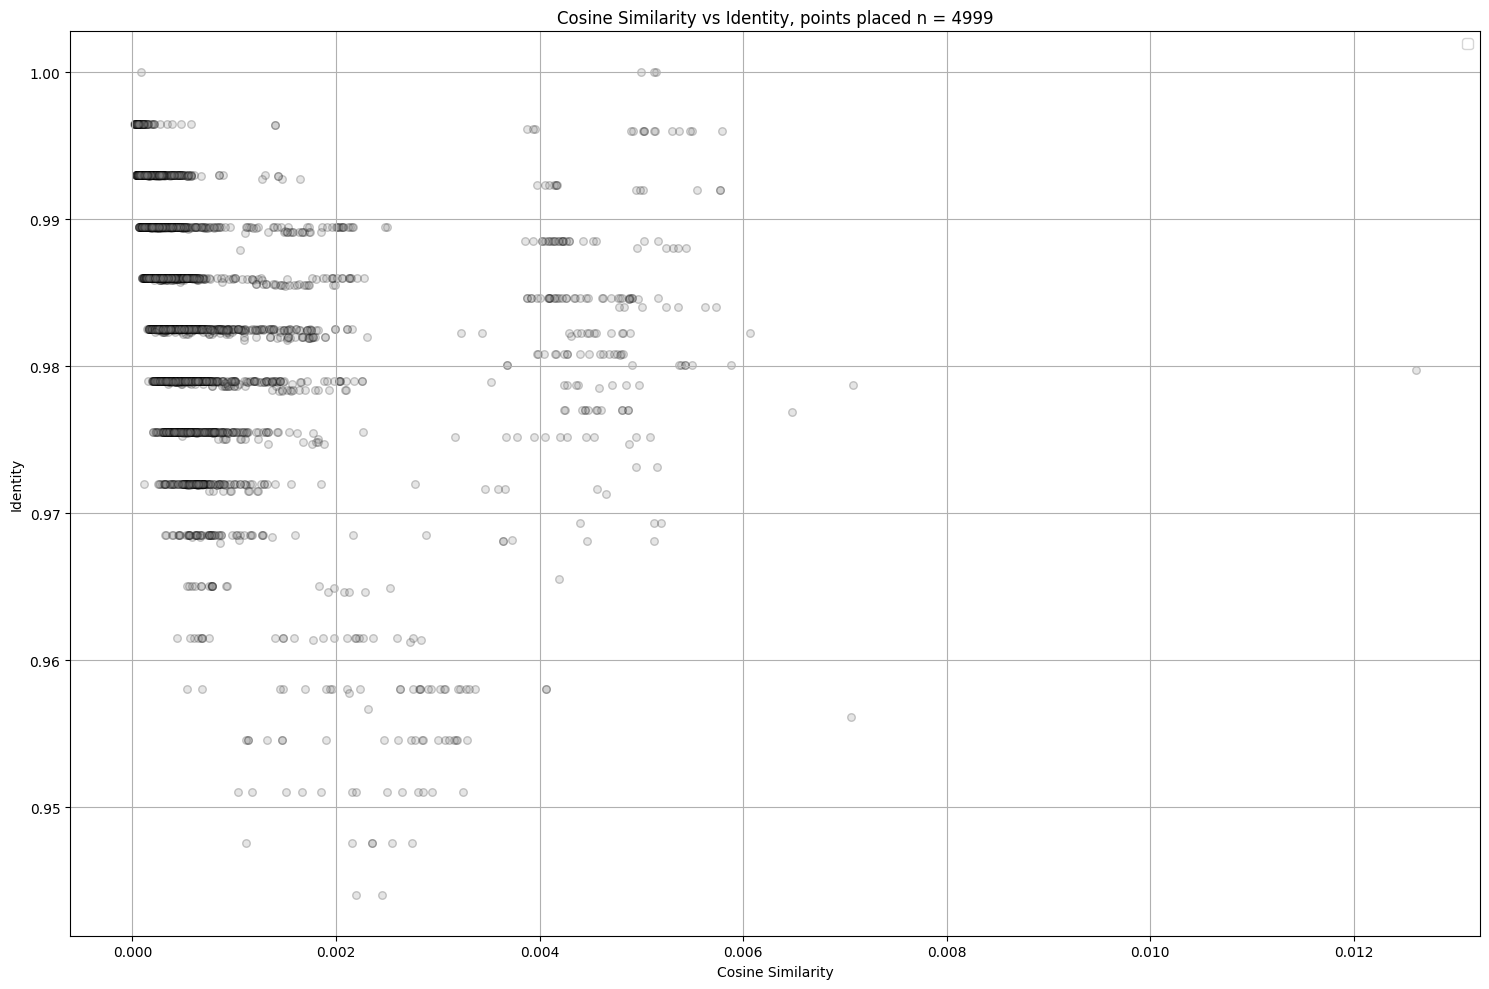

In [46]:
fig = plt.figure(figsize=(15, 10))

number_of_points_goal = 5000
total_number_of_points = distance_matrix_embedding_cosine.shape[0] * distance_matrix_embedding_cosine.shape[1]
random_chance_probability = number_of_points_goal / total_number_of_points
point_counter = 0

data_matrix = []

protein_ids_embedding = np.array(protein_ids_embedding)
protein_ids_pairwise = np.array(protein_ids_pairwise)

print(f" Length of protein_ids_mutations: {len(protein_ids_embedding)}")
print(f" Length of protein_ids_pairwise: {len(protein_ids_pairwise)}")

for i in range(len(protein_ids_embedding)):
    for j in range(len(protein_ids_pairwise)):

        if np.random.rand() < random_chance_probability:
            # plt.scatter(distance_matrix_mutations[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            # does not work since the ids are not the same

            mutations_id = protein_ids_embedding[i]
            pairwise_id = protein_ids_pairwise[j]

            if mutations_id == pairwise_id:
                plt.scatter(distance_matrix_embedding_cosine[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
                data_matrix.append([distance_matrix_embedding_cosine[i, j], distance_matrix_pairwise[i, j], mutations_id, pairwise_id])
            else:
                # we need to find the index of the pairwise_id in the protein_ids_mutations array from numpy
                # the i is the index in the protein_ids_mutations array this means we are looking of the index to j in the protein_ids_mutations array
                index_mutations_id = np.where(protein_ids_embedding == pairwise_id)[0][0]
                # now the index of the mutations_id is the index of the pairwise_id in the protein_ids_pairwise array
                index_pairwise_id = np.where(protein_ids_pairwise == mutations_id)[0][0]

                plt.scatter(distance_matrix_embedding_cosine[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], c='gray', alpha=0.2, s=30, edgecolor="k")
                data_matrix.append([distance_matrix_embedding_cosine[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], mutations_id, pairwise_id])
            
            point_counter += 1
        
        if point_counter > number_of_points_goal:
            break
        
    
plt.title("Cosine Similarity vs Identity, points placed n = " + str(point_counter))
plt.xlabel("Cosine Similarity")
plt.ylabel("Identity")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
data_matrix_ARRAY = np.array(data_matrix)
# the first column is the cosine similarity, the second is the identity, the third is the mutations_id and the fourth is the pairwise_id
# there fore the first two should be of type float and the last two of type string
data_matrix_ARRAY[:, 0] = data_matrix_ARRAY[:, 0].astype(float)
data_matrix_ARRAY[:, 1] = data_matrix_ARRAY[:, 1].astype(float)
data_matrix_ARRAY[:, 2] = data_matrix_ARRAY[:, 2].astype(str)
data_matrix_ARRAY[:, 3] = data_matrix_ARRAY[:, 3].astype(str)

print(data_matrix_ARRAY.shape)

# find the point with identity 1 and a cosine of bigger than 0.003
# then outpur the ids
for i in range(len(data_matrix_ARRAY)):
    if float(data_matrix_ARRAY[i, 1]) > 0.99999 and float(data_matrix_ARRAY[i, 0]) > 0.003:
        print('......................')
        print(data_matrix_ARRAY[i, 2], data_matrix_ARRAY[i, 3])
        print(f"Identity: {data_matrix_ARRAY[i, 1]}, Cosine Similarity: {data_matrix_ARRAY[i, 0]}")
        print(f"Label of {data_matrix_ARRAY[i, 2]}: {dict_id_label_new_ids_none[data_matrix_ARRAY[i, 2]]}")
        print(f"Label of {data_matrix_ARRAY[i, 3]}: {dict_id_label_new_ids_none[data_matrix_ARRAY[i, 3]]}")
        print('......................')
        print('\n')

(4999, 4)
......................
AGQ50511.1 AEQ59620.1
Identity: 1.0, Cosine Similarity: 0.005139770029669144
Label of AGQ50511.1: 2br
Label of AEQ59620.1: None
......................


......................
AEQ59620.1 CBX53726.1
Identity: 1.0, Cosine Similarity: 0.00499522616870296
Label of AEQ59620.1: None
Label of CBX53726.1: 2br
......................


......................
CAA64682.1 AEQ59620.1
Identity: 1.0, Cosine Similarity: 0.005122564896320458
Label of CAA64682.1: 2br
Label of AEQ59620.1: None
......................




/tmp/ipykernel_673301/1718172517.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


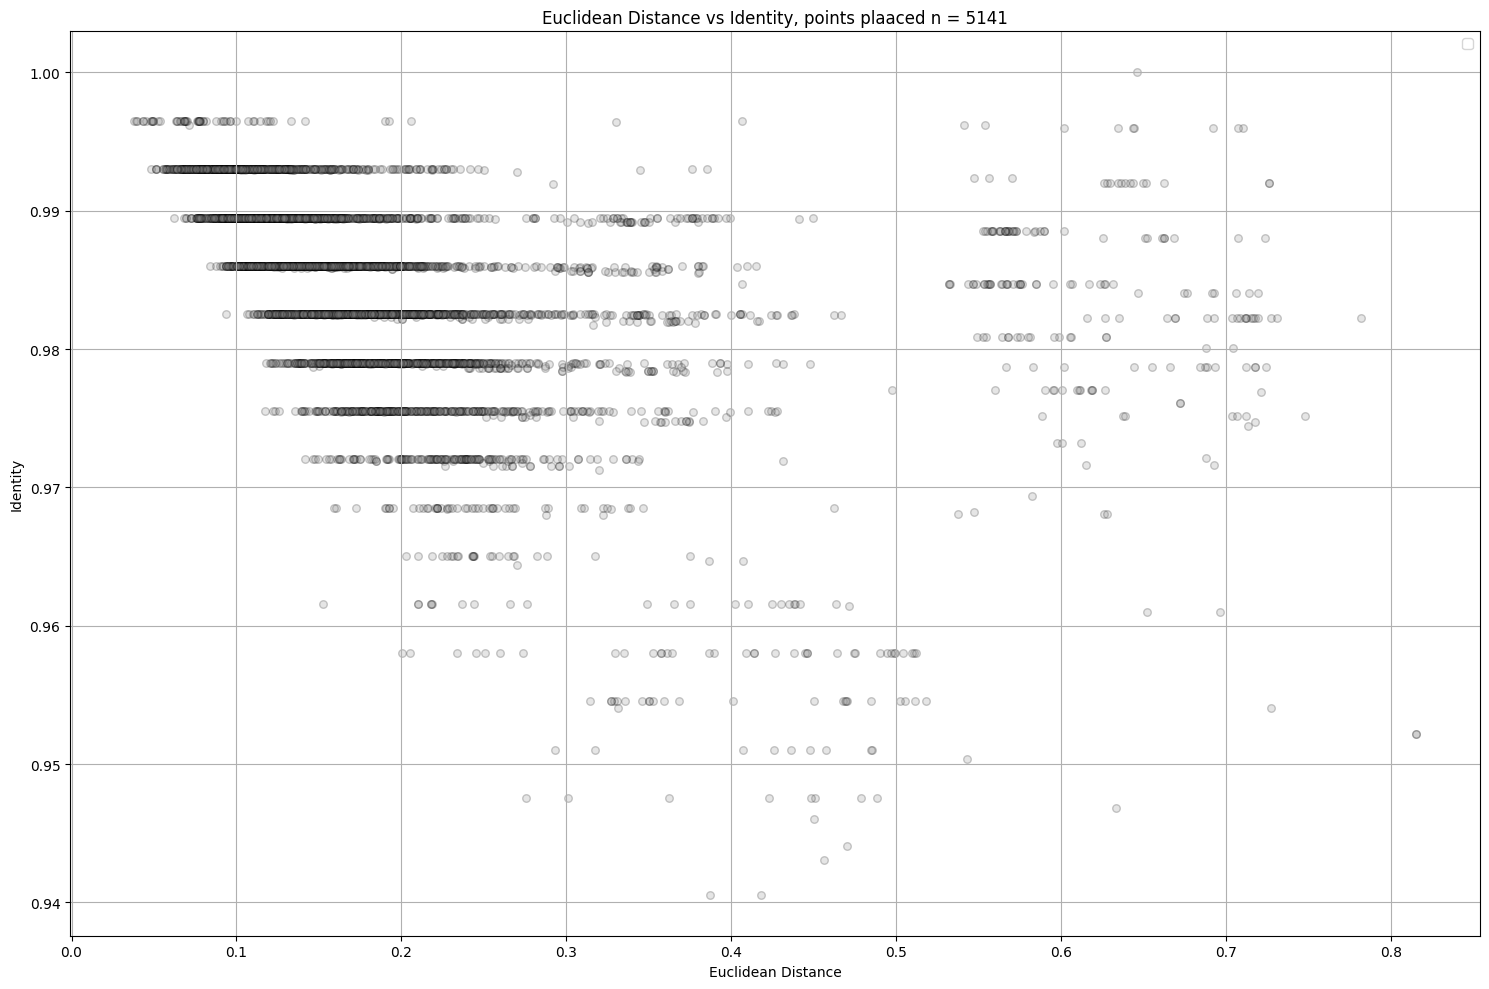

In [35]:
# same plot as before but with euclidean distance

fig = plt.figure(figsize=(15, 10))

number_of_points_goal = 5000
total_number_of_points = distance_matrix_embedding_euclidean.shape[0] * distance_matrix_embedding_euclidean.shape[1]
random_chance_probability = number_of_points_goal / total_number_of_points
point_counter = 0

for i in range(len(protein_ids_embedding)):
    for j in range(len(protein_ids_pairwise)):

        if np.random.rand() < random_chance_probability:
            # plt.scatter(distance_matrix_embedding_euclidean[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            # does not work since the ids are not the same

            mutations_id = protein_ids_embedding[i]
            pairwise_id = protein_ids_pairwise[j]

            if mutations_id == pairwise_id:
                plt.scatter(distance_matrix_embedding_euclidean[i, j], distance_matrix_pairwise[i, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            else:
                # we need to find the index of the pairwise_id in the protein_ids_mutations array from numpy
                # the i is the index in the protein_ids_mutations array this means we are looking of the index to j in the protein_ids_mutations array
                index_mutations_id = np.where(protein_ids_embedding == pairwise_id)[0][0]
                # now the index of the mutations_id is the index of the pairwise_id in the protein_ids_pairwise array
                index_pairwise_id = np.where(protein_ids_pairwise == mutations_id)[0][0]

                plt.scatter(distance_matrix_embedding_euclidean[i, index_mutations_id], distance_matrix_pairwise[index_pairwise_id, j], c='gray', alpha=0.2, s=30, edgecolor="k")
            
            point_counter += 1
        
plt.title("Euclidean Distance vs Identity, points placed n = " + str(point_counter))
plt.xlabel("Euclidean Distance")
plt.ylabel("Identity")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


21736


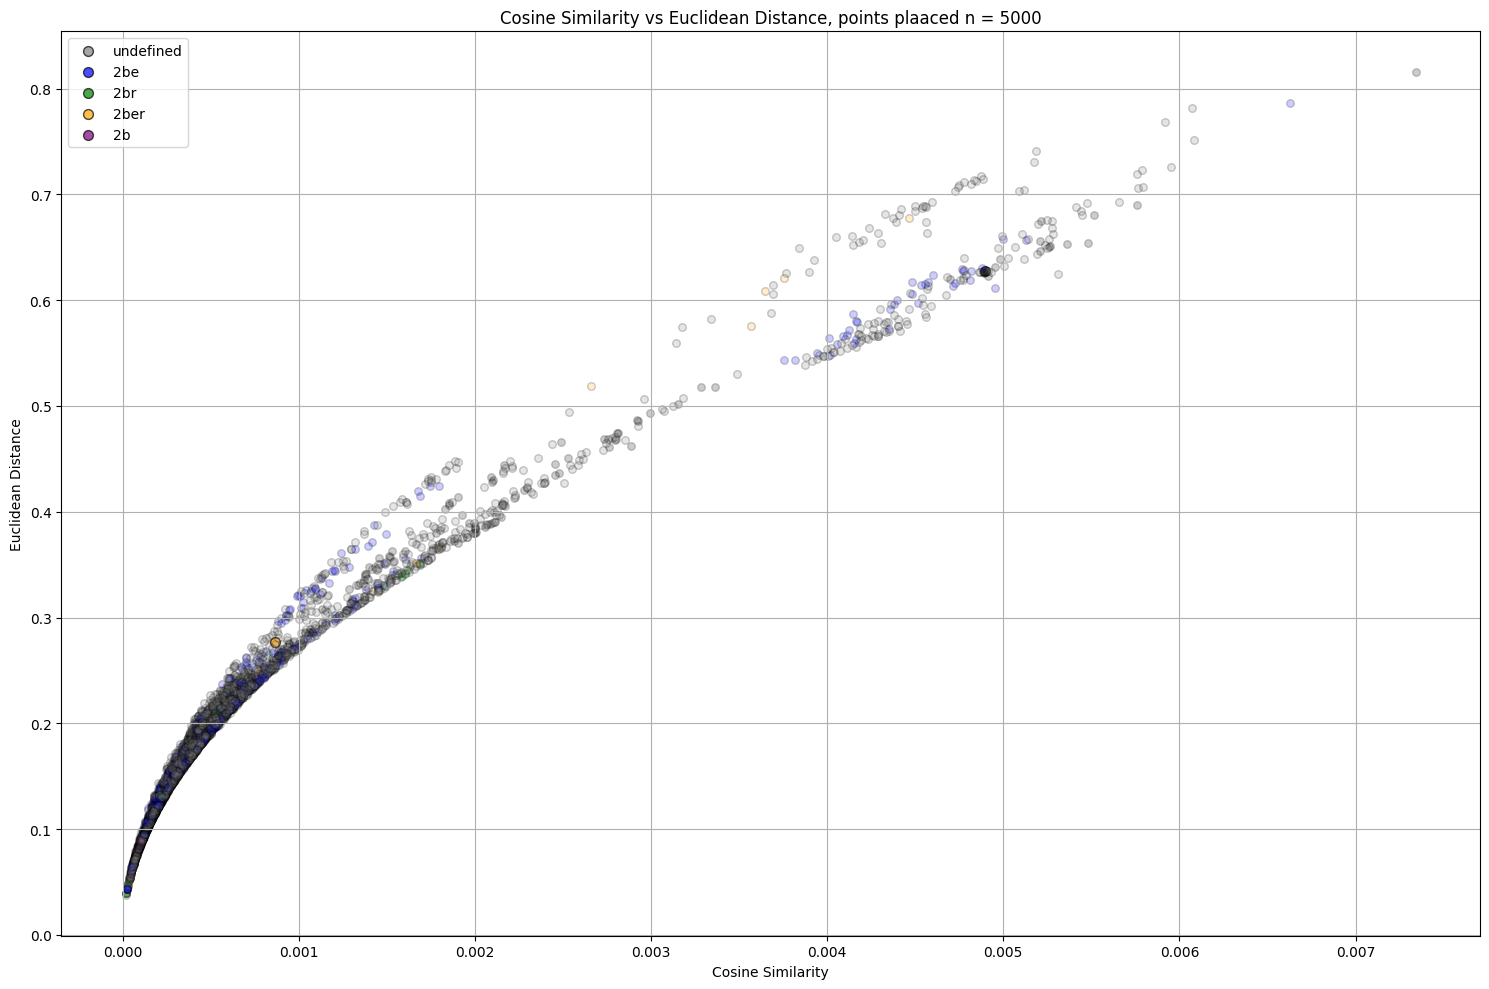

In [25]:
# create the scatter plot with cosine vs euclidian

fig = plt.figure(figsize=(15, 10))

# tracking
count_points = 0
already_plotted_labels = set()

# get all combinations of indexes but skip the second half of the matrix
combinations_of_indexes = list(itertools.combinations(range(len(protein_ids)), 2))
print(len(combinations_of_indexes))
total_number = len(combinations_of_indexes)
random_choices = np.random.choice(total_number, 5000, replace=False)


for index in random_choices:

    i = combinations_of_indexes[index][0]
    j = combinations_of_indexes[index][1]
    if i == j:
        continue

    if colors[i, j] == 'gray':
        label = 'undefined'
    else:
        label = dict_id_label_new_ids_none[protein_ids_embedding[i]]

    if label in already_plotted_labels:
        plt.scatter(
            distance_matrix_embedding_cosine[i, j],
            distance_matrix_embedding_euclidean[i, j],
            c=colors[i, j],
            alpha=0.2,
            s=30,
            edgecolor="k",
        )

    else:
        plt.scatter(
            distance_matrix_embedding_cosine[i, j],
            distance_matrix_embedding_euclidean[i, j],
            c=colors[i, j],
            label=label,
            alpha=0.7,
            s=50,
            edgecolor="k",
        )
        already_plotted_labels.add(label)

    count_points += 1

    if count_points > 20000:
        break

plt.title("Cosine Similarity vs Euclidean Distance, points plaaced n = " + str(count_points))
plt.xlabel("Cosine Similarity")
plt.ylabel("Euclidean Distance")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()




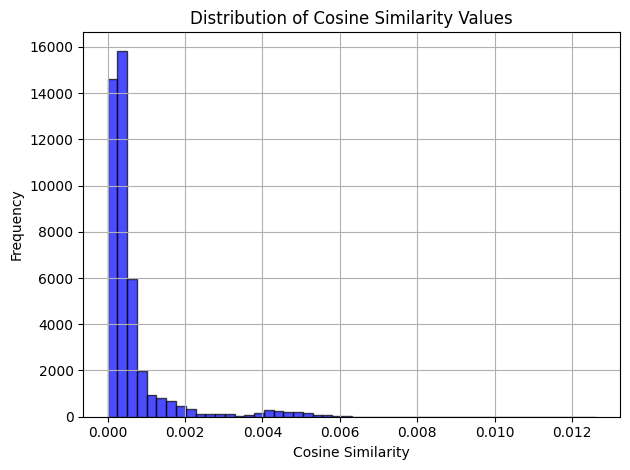

In [26]:
# plot the distribution of the cosine similarity values on a histogram
# use the cosine similarity values from the distance matrix

plt.hist(distance_matrix_embedding_cosine.flatten(), bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Cosine Similarity Values")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()

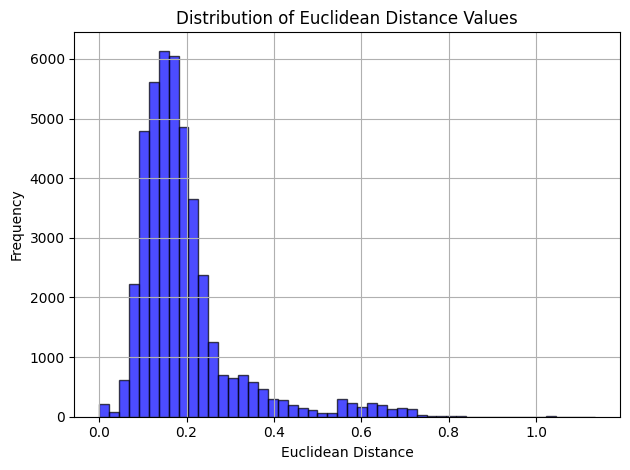

In [27]:
# plot the distribution of the euclidean distance values on a histogram
# use the euclidean distance values from the distance matrix

plt.hist(distance_matrix_embedding_euclidean.flatten(), bins=50, color="blue", alpha=0.7, edgecolor="k")
plt.title("Distribution of Euclidean Distance Values")
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.grid()
plt.tight_layout()
plt.show()


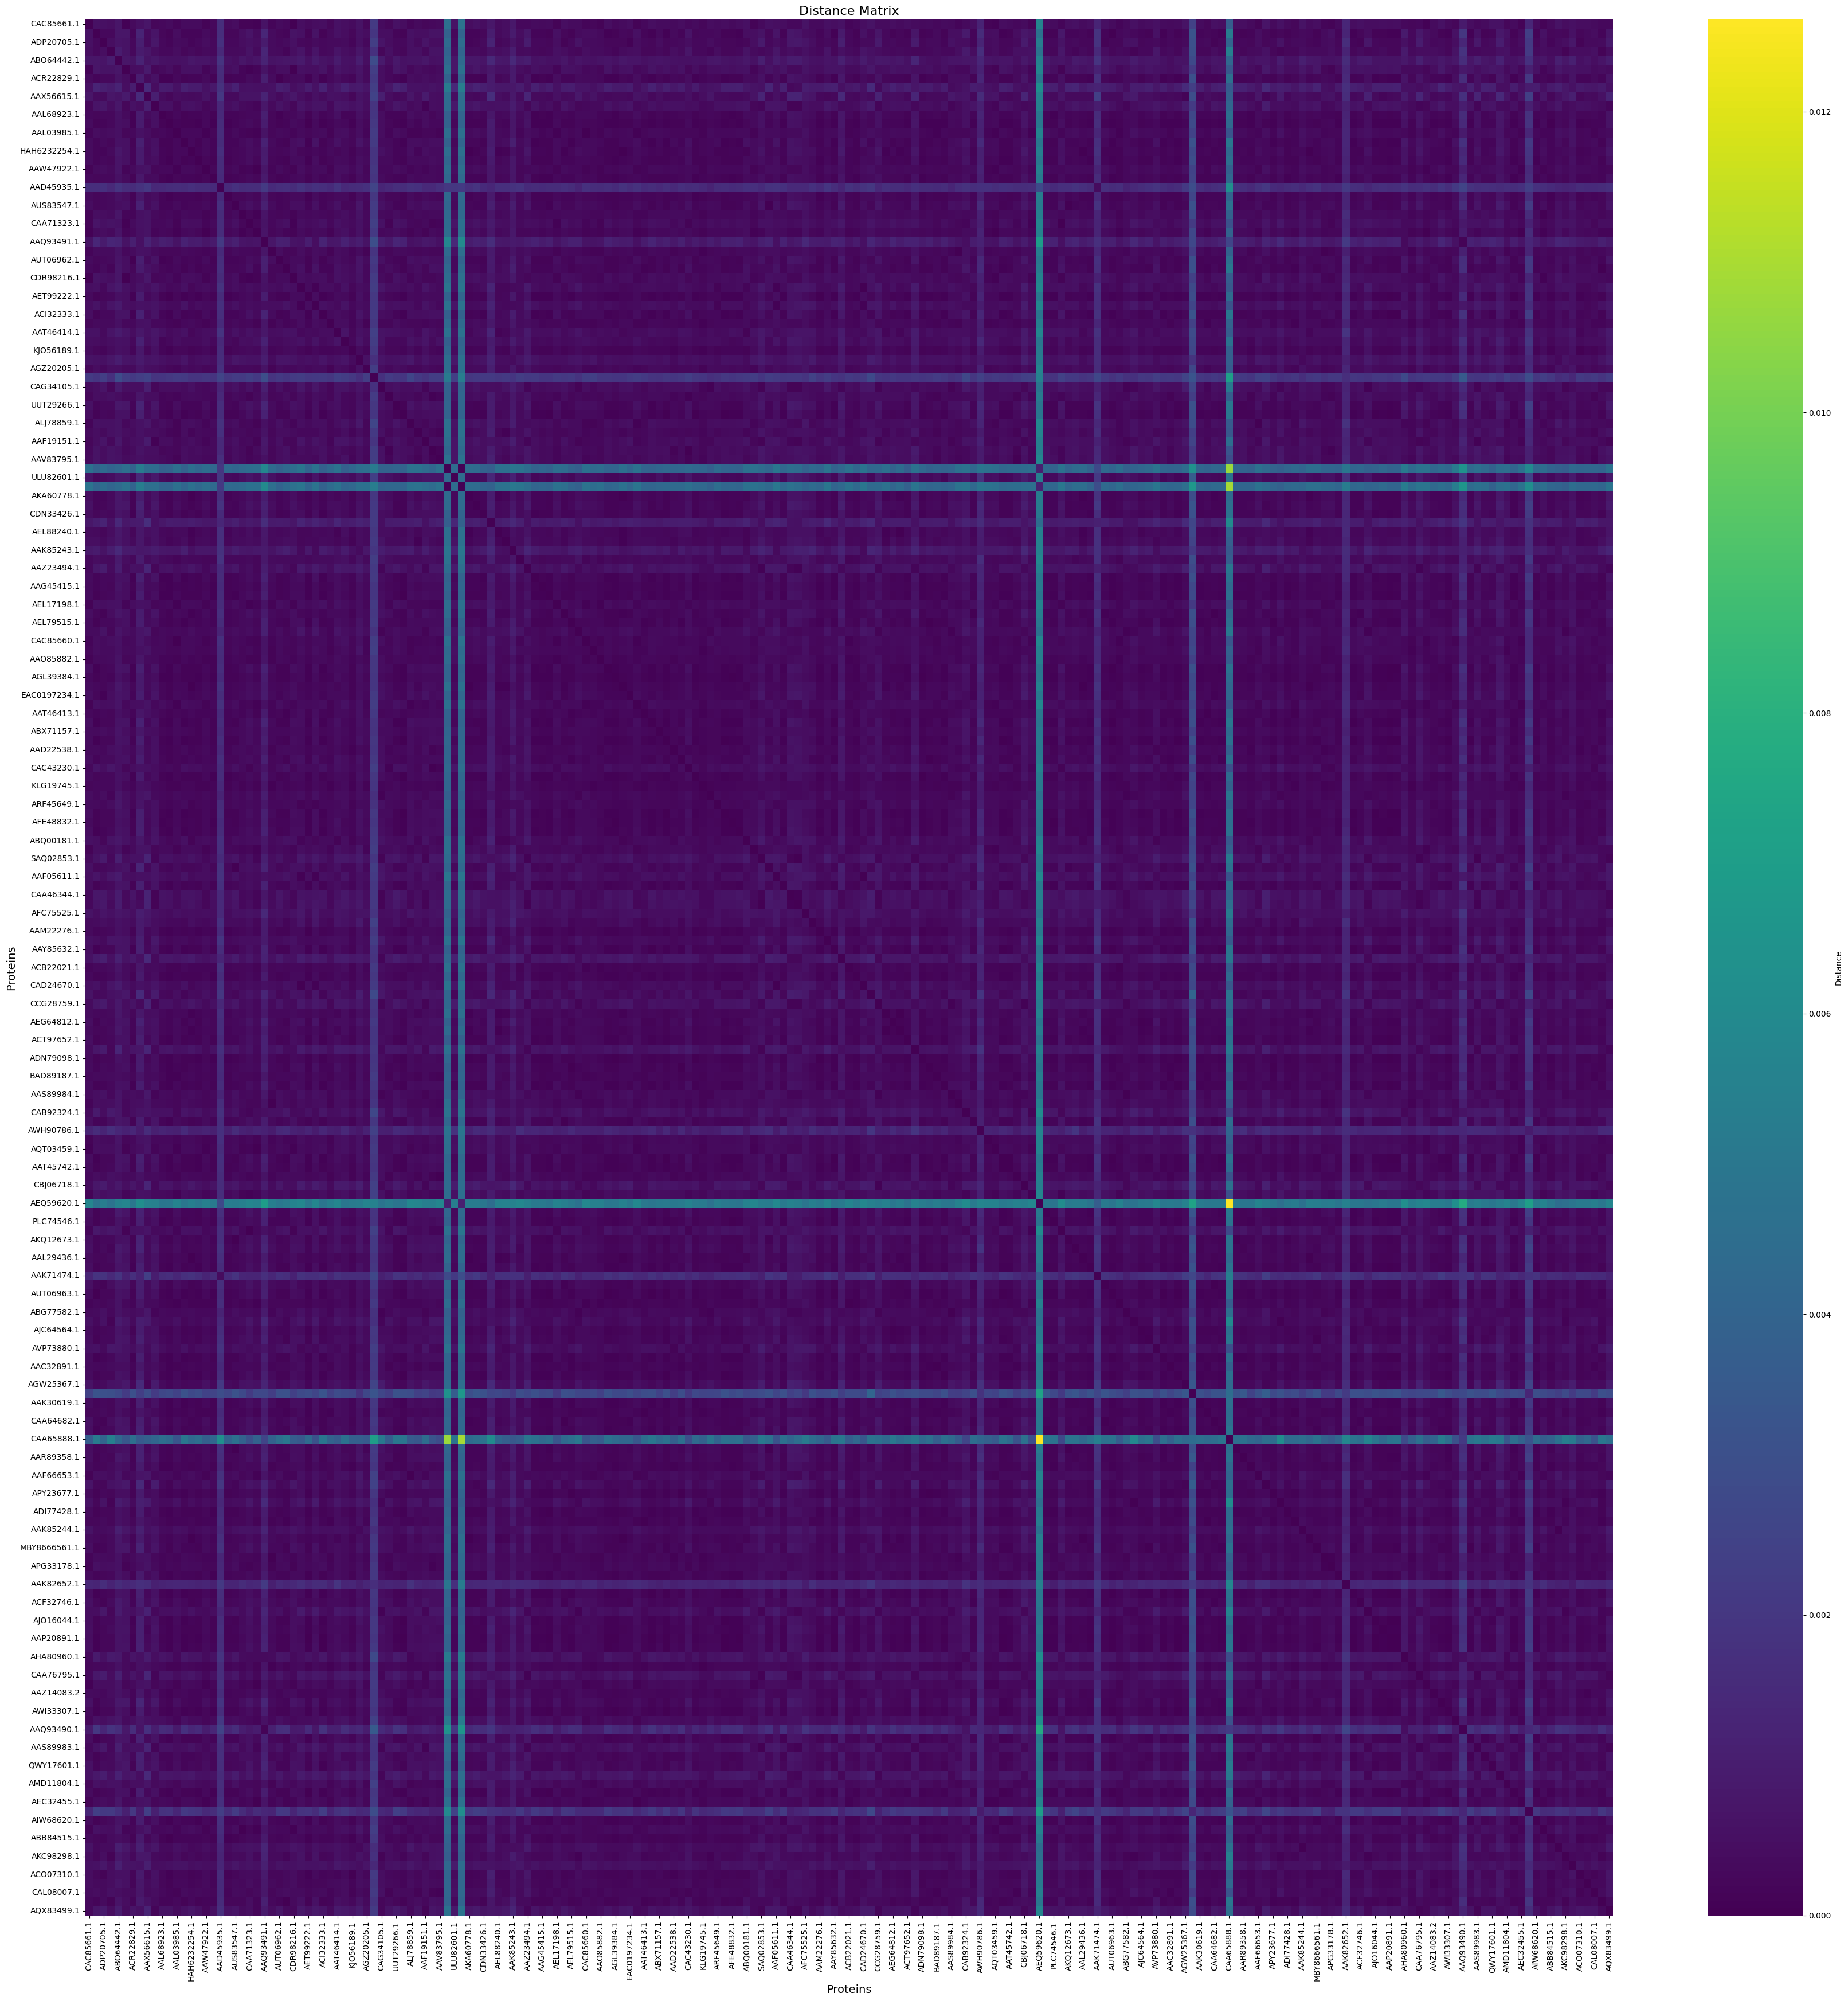

In [17]:
import seaborn as sns

# Example data
proteins = protein_ids
distances = distance_matrix_embedding_cosine

# Convert the distance array to a DataFrame for better labeling
distance_df = pd.DataFrame(distances, index=proteins, columns=proteins)

# Plot the heatmap
plt.figure(figsize=(35, 35))
sns.heatmap(
    distance_df, 
    annot=False,
    fmt=".2f",           
    cmap="viridis",      
    cbar_kws={'label': 'Distance'},
    annot_kws={"size": 2},
)

# Add titles and labels
plt.title("Distance Matrix", fontsize=16)
plt.xlabel("Proteins", fontsize=14)
plt.ylabel("Proteins", fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()